In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import numpyro

NDEVICES = 16
numpyro.set_host_device_count(NDEVICES)

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc

import pystarboard.data

from cel_utils import disk_utils

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
token = os.path.join(os.environ['HOME'],'code/auth/spacescope_auth.json')
print(os.path.exists(token))

mcmc_train_len_days = 120
current_date = date(2024, 1, 8)

#current_date = date.today() - timedelta(days=3)
start_date = current_date - timedelta(days=60) # get some historical data
forecast_length = 365*2
end_date = current_date + timedelta(days=forecast_length)
print(start_date, current_date, end_date)

False
2023-11-09 2024-01-08 2026-01-07


In [5]:
save_dir = os.path.join(os.environ['HOME'], 'Documents/cel/filecoin_forecasts/%s/%d' % (current_date.strftime('%Y%m%d'), mcmc_train_len_days))
offline_info_dir = os.path.join(save_dir, 'offline_info')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_info_dir, exist_ok=True)

In [6]:
pystarboard.data.setup_spacescope(token)

In [7]:
@disk_utils.cache_data(directory=offline_info_dir)
def download_simulation_data():
    offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
    return {
        'offline_data': offline_data
    }

x = download_simulation_data()
locals().update(x)

### Run MCMC Forecast of Network Metrics

In [8]:
# MCMC forecasting configuration
mcmc_train_start_date = current_date - timedelta(days=(mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 10000
num_samples_mcmc = 500
seasonality_mcmc = 2000
num_chains_mcmc = 4

In [9]:
def generate_mcmc_forecast_samples(train_start_date: date,
                                   train_end_date: date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2,
                                   verbose: bool = False):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, historical_rb_date, historical_rb, rb_rhats = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc,
                                       verbose = verbose)
    
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, historical_rr_date , historical_rr, ext_rhats, expire_rhats = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc,
                                   verbose = verbose)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, historical_fpr_date, historical_fpr, deal_onboard_pred_rhats, cc_onboard_pred_rhats = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc,
                                   verbose = verbose)
    
    diagnostics = {
        'rb_rhats': rb_rhats,
        'ext_rhats': ext_rhats,
        'expire_rhats': expire_rhats,
        'deal_onboard_pred_rhats':deal_onboard_pred_rhats, 
        'cc_onboard_pred_rhats': cc_onboard_pred_rhats
    }
    
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, historical_fpr_date, historical_fpr, diagnostics
    
@disk_utils.cache_data(directory=offline_info_dir)
def run_mcmc():
    rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, historical_fpr_date, historical_fpr, diagnostics = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc,
                                       verbose=True)
    return {
        'rb_onboard_power_pred': rb_onboard_power_pred,
        'renewal_rate_pred': renewal_rate_pred,
        'filplus_rate_pred': filplus_rate_pred,
        'historical_rb_date': historical_rb_date,
        'historical_rb': historical_rb,
        'historical_rr_date': historical_rr_date,
        'historical_rr': historical_rr,
        'historical_fpr_date': historical_fpr_date,
        'historical_fpr': historical_fpr,
        'diagnostics': diagnostics
    }

mcmc_data = run_mcmc()
locals().update(mcmc_data)

# print mcmc diagnostics
rb_rhat_check = mcmc.check_rhat(diagnostics['rb_rhats'])
ext_rhat_check = mcmc.check_rhat(diagnostics['ext_rhats'])
exp_rhat_check = mcmc.check_rhat(diagnostics['expire_rhats'])

print('RBP Forecast RHat < 1.05: %0.02f %%' % (rb_rhat_check*100,))
print('Extensions Forecast RHat < 1.05: %0.02f %%' % (ext_rhat_check*100,))
print('Expirations Forecast RHat < 1.05: %0.02f %%' % (exp_rhat_check*100,))

RBP Forecast RHat < 1.05: 100.00 %
Extensions Forecast RHat < 1.05: 96.12 %
Expirations Forecast RHat < 1.05: 96.12 %


In [10]:
def get_quantiles(jax_arr, qvec=[0.25, 0.5, 0.75]):
    return np.quantile(jax_arr, qvec, axis=0)

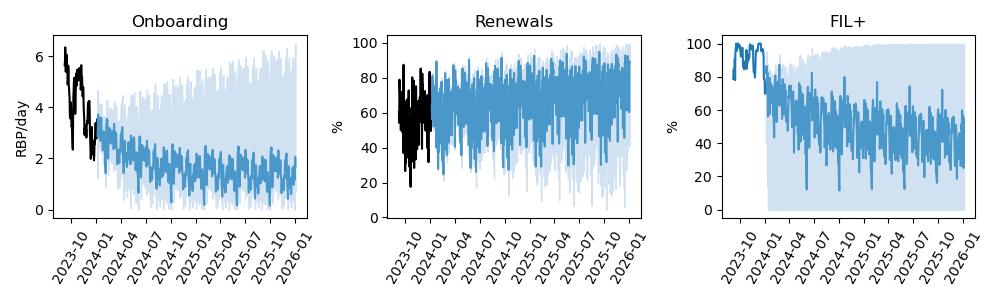

In [11]:
# plot historical trends
t_pred = pd.date_range(historical_rb_date.iloc[-1]+timedelta(days=1), periods=forecast_length, freq='D')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3), sharex=True)

blues = mpl.colormaps['Blues']
axx = ax[0]
axx.plot(historical_rb_date, historical_rb, color='k')
rbp_quantiles = get_quantiles(rb_onboard_power_pred)
axx.plot(t_pred, rbp_quantiles[1], color=blues(0.6))
axx.fill_between(t_pred, rbp_quantiles[0], rbp_quantiles[2], color=blues(0.2))
axx.set_title('Onboarding')
axx.set_ylabel('RBP/day')
for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
axx = ax[1]
axx.plot(historical_rr_date, historical_rr*100, color='k')
rr_quantiles = get_quantiles(renewal_rate_pred*100)
axx.plot(t_pred, rr_quantiles[1], color=blues(0.6))
axx.fill_between(t_pred, rr_quantiles[0], rr_quantiles[2], color=blues(0.2))
axx.set_title('Renewals')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[2]
axx.plot(historical_fpr_date, historical_fpr*100)
fpr_quantiles = get_quantiles(filplus_rate_pred*100)
axx.plot(t_pred, fpr_quantiles[1], color=blues(0.6))
axx.fill_between(t_pred, fpr_quantiles[0], fpr_quantiles[2], color=blues(0.2))
axx.set_title('FIL+')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'mcmc_inputs.png'))

In [12]:
lock_target = 0.3
sector_duration = 365

simulation_results_vec = []
for ii in tqdm(range(num_samples_mcmc*num_chains_mcmc)):
    rbp_vec = rb_onboard_power_pred[ii,:]
    rr_vec = renewal_rate_pred[ii,:]
    fpr_vec = filplus_rate_pred[ii,:]
    simulation_results = sim.run_sim(
        rbp_vec,
        rr_vec,
        fpr_vec,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    simulation_results_vec.append(simulation_results)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [14]:
end_date = current_date + timedelta(forecast_length)
macro_t = du.get_t(start_date, end_date=end_date)

In [15]:
def get_simresults_quantiles(sim_results_vec, key, qvec=[0.25, 0.5, 0.75]):
    key_results = []
    for sr in sim_results_vec:
        key_results.append(np.asarray(sr[key]))  # convert jax to np
    
    return np.nanquantile(np.asarray(key_results), qvec, axis=0)

def plot_mcmc_power_panel(simulation_results_vec):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    axx = ax[0]
    yy = get_simresults_quantiles(simulation_results_vec, key='rb_total_power_eib')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    axx.set_ylabel('EiB')
    axx.set_title('RBP')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    axx = ax[1]
    yy = get_simresults_quantiles(simulation_results_vec, key='qa_total_power_eib')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    baseline = get_simresults_quantiles(simulation_results_vec, key='network_baseline_EIB', qvec=[0.5])
    axx.plot(macro_t, baseline[0], color='k')
    axx.set_ylabel('EiB')
    axx.set_title('QAP')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    axx = ax[2]
    yy = get_simresults_quantiles(simulation_results_vec, key='day_network_reward')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    axx.set_ylabel('FIL/day')
    axx.set_title('Minting Rate')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    plt.suptitle('Power Metrics')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'mcmc_power.png'))

def plot_supply_panel(simulation_results_vec):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    axx = ax[0]
    yy = get_simresults_quantiles(simulation_results_vec, key='network_locked')
    axx.plot(macro_t, yy[1]/1e6, color=blues(0.6))
    axx.fill_between(macro_t, yy[0]/1e6, yy[2]/1e6, color=blues(0.2))
    axx.set_ylabel('M-FIL')
    axx.set_title('Network Locked')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    axx = ax[1]
    yy = get_simresults_quantiles(simulation_results_vec, key='circ_supply')
    axx.plot(macro_t, yy[1]/1e6, color=blues(0.6))
    axx.fill_between(macro_t, yy[0]/1e6, yy[2]/1e6, color=blues(0.2))
    axx.set_ylabel('M-FIL')
    axx.set_title('Circulating Supply')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    key_results = []
    for sr in simulation_results_vec:
        key_results.append(np.asarray(sr['network_locked']/sr['circ_supply']))  # convert jax to np
    lcs_q = np.quantile(np.asarray(key_results), [0.25, 0.5, 0.75], axis=0)
    axx = ax[2]
    axx.plot(macro_t, lcs_q[1]*100, color=blues(0.6))
    axx.fill_between(macro_t, lcs_q[0]*100, lcs_q[2]*100, color=blues(0.2))
    axx.set_ylabel('%')
    axx.set_title('L/CS')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    plt.suptitle('Supply Metrics')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'mcmc_supply.png'))

def plot_onboarding_panel(simulation_results_vec):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    axx = ax[0]
    yy = get_simresults_quantiles(simulation_results_vec, key='day_pledge_per_QAP')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    axx.set_ylabel('FIL')
    axx.set_title('Pledge/32GiB QA Sector')
    axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    axx = ax[1]
    key_results = []
    for sr in simulation_results_vec:
        key_results.append(np.asarray(sr['1y_sector_roi']*100))  # convert jax to np
    fofr = np.nanquantile(np.asarray(key_results), [0.25, 0.5, 0.75], axis=0)
    axx.plot(macro_t[0:len(fofr[0])], fofr[1], color=blues(0.6))
    axx.fill_between(macro_t[0:len(fofr[0])], fofr[0], fofr[2], color=blues(0.2))
    axx.set_ylabel('%')
    axx.set_title('1Y Realized FoFR')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
    plt.suptitle('Onboarding Metrics')
    plt.tight_layout()

    plt.savefig(os.path.join(save_dir, 'mcmc_onboarding.png'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


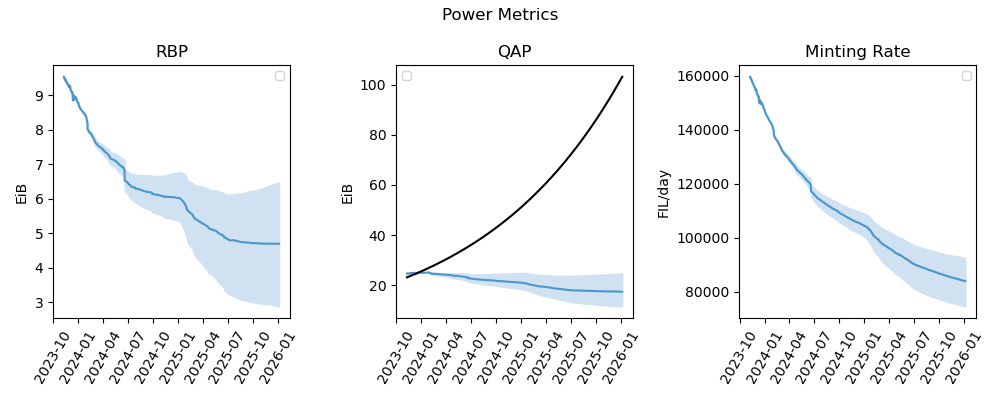

In [16]:
plot_mcmc_power_panel(simulation_results_vec)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


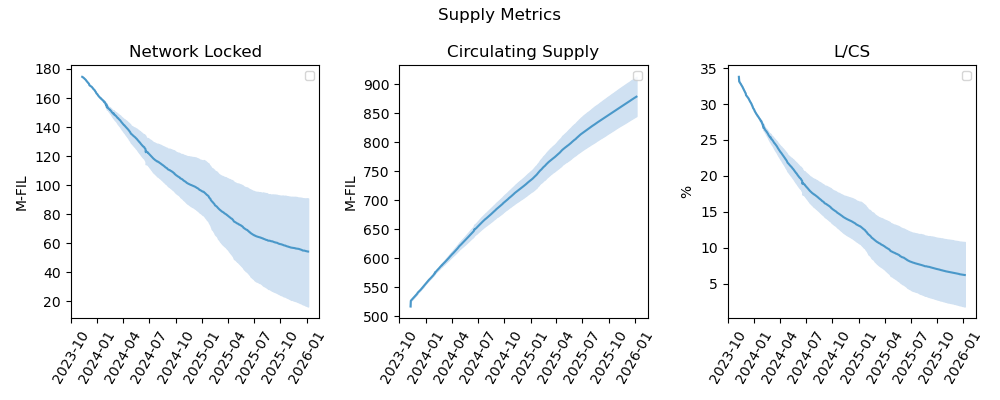

In [17]:
plot_supply_panel(simulation_results_vec)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


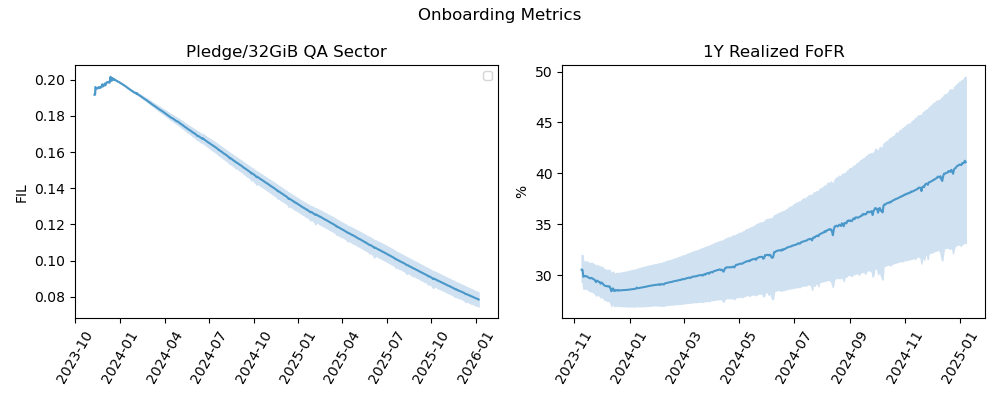

In [18]:
plot_onboarding_panel(simulation_results_vec)

### Run several scenarios scaled from the current Median Rates of RBP, RR, FPR

In [19]:
hist_median_rbp = np.median(historical_rb)
hist_median_rr = np.median(historical_rr)
hist_median_fpr = np.median(historical_fpr)

print(hist_median_rbp, hist_median_rr, hist_median_fpr)

4.17620849609375 0.5846854900127445 0.9543612


In [20]:
rbp_factors = [0.8, 1.2]
rr_factors = [0.8, 1.2]
fpr_factors = [0.8, 1.2]

sim_configs = list(itertools.product(rbp_factors, rr_factors, fpr_factors))
sim_configs.insert(0, (1,1,1))

lock_target = 0.3
sector_duration = 365

simconfig2results = {}
for sim_config in sim_configs:
    rbp_factor, rr_factor, fpr_factor = sim_config
    rbp_vec = jnp.ones(forecast_length) * hist_median_rbp * rbp_factor
    rr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_rr * rr_factor)
    fpr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_fpr * fpr_factor)

    simulation_results = sim.run_sim(
        rbp_vec,
        rr_vec,
        fpr_vec,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    simconfig2results[sim_config] = simulation_results

In [21]:
def plot_power_scenarios():
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges']]
    intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    axx = ax[0]
    for sim_config, sim_results in simconfig2results.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['rb_total_power_eib'], color=c, linestyle=l)
    axx.set_ylabel('EiB')
    axx.set_title('RBP')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    # setup the legend
    custom_lines = [
        Line2D([0], [0], color=colors[0](0.3), lw=2),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color=colors[1](0.7), lw=2)
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='RBP Factor')

    axx = ax[1]
    for sim_config, sim_results in simconfig2results.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['qa_total_power_eib'], color=c, linestyle=l)
    axx.plot(macro_t, sim_results['network_baseline_EIB'], color='k', linestyle='--')
    axx.set_ylabel('EiB')
    axx.set_title('QAP')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    # setup the legend
    # setup the legend
    custom_lines = [
        Line2D([0], [0], color='k', lw=2, linestyle='-.'),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color='k', lw=2, linestyle=':'),
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='FPR Factor')
    
    axx = ax[2]
    for sim_config, sim_results in simconfig2results.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['day_network_reward'], color=c, linestyle=l)
    axx.set_ylabel('FIL/day')
    axx.set_title('Minting Rate')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    custom_lines = [
        Line2D([0], [0], color=mpl.colormaps['Greys'](intensities[0]), lw=2),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color=mpl.colormaps['Greys'](intensities[1]), lw=2),
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='RR Factor')
    
    plt.suptitle('Power Metrics')
    plt.tight_layout()

    plt.savefig(os.path.join(save_dir, 'scenarios_power.png'))

def plot_supply_scenarios():
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges']]
    intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    axx = ax[0]
    for sim_config, sim_results in simconfig2results.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['network_locked']/1e6, color=c, linestyle=l)
    axx.set_ylabel('M-FIL')
    axx.set_title('Network Locked')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    # setup the legend
    custom_lines = [
        Line2D([0], [0], color=colors[0](0.3), lw=2),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color=colors[1](0.7), lw=2)
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='RBP Factor')

    axx = ax[1]
    for sim_config, sim_results in simconfig2results.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['circ_supply']/1e6, color=c, linestyle=l)
    axx.set_ylabel('M-FIL')
    axx.set_title('Circulating Supply')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    # setup the legend
    custom_lines = [
        Line2D([0], [0], color='k', lw=2, linestyle='-.'),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color='k', lw=2, linestyle=':'),
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='FPR Factor')
    
    axx = ax[2]
    for sim_config, sim_results in simconfig2results.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['network_locked']/sim_results['circ_supply']*100, color=c, linestyle=l)
    axx.set_ylabel('%%')
    axx.set_title('L/CS')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    custom_lines = [
        Line2D([0], [0], color=mpl.colormaps['Greys'](intensities[0]), lw=2),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color=mpl.colormaps['Greys'](intensities[1]), lw=2),
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='RR Factor')
    
    plt.suptitle('Supply Metrics')
    plt.tight_layout()

    plt.savefig(os.path.join(save_dir, 'scenarios_supply.png'))

def plot_onboarding_scenarios():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges']]
    intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    axx = ax[0]
    for sim_config, sim_results in simconfig2results.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['day_pledge_per_QAP'], color=c, linestyle=l)
    axx.set_ylabel('FIL')
    axx.set_title('Pledge/32GiB QAP Sector')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    # setup the legend
    custom_lines = [
        Line2D([0], [0], color=colors[0](0.3), lw=2),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color=colors[1](0.7), lw=2)
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='RBP Factor')

    axx = ax[1]
    for sim_config, sim_results in simconfig2results.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]

        fofr = sim_results['1y_sector_roi']*100
        axx.plot(macro_t[0:len(fofr)], fofr, color=c, linestyle=l)
    axx.set_ylabel('FIL')
    axx.set_title('Pledge/32GiB QAP Sector')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    custom_lines = [
        Line2D([0], [0], color='k', lw=2, linestyle='-.'),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color='k', lw=2, linestyle=':'),
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='FPR Factor')

    plt.suptitle('Onboarding Metrics')
    plt.tight_layout()

    plt.savefig(os.path.join(save_dir, 'scenarios_onboarding.png'))

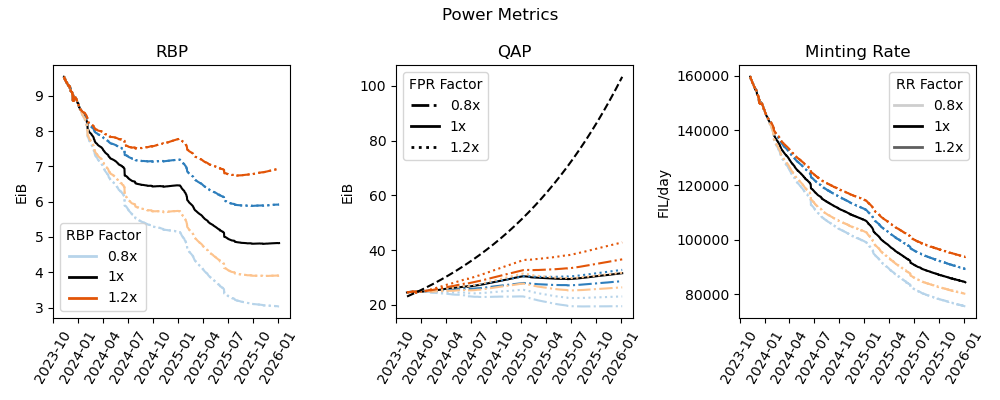

In [22]:
plot_power_scenarios()

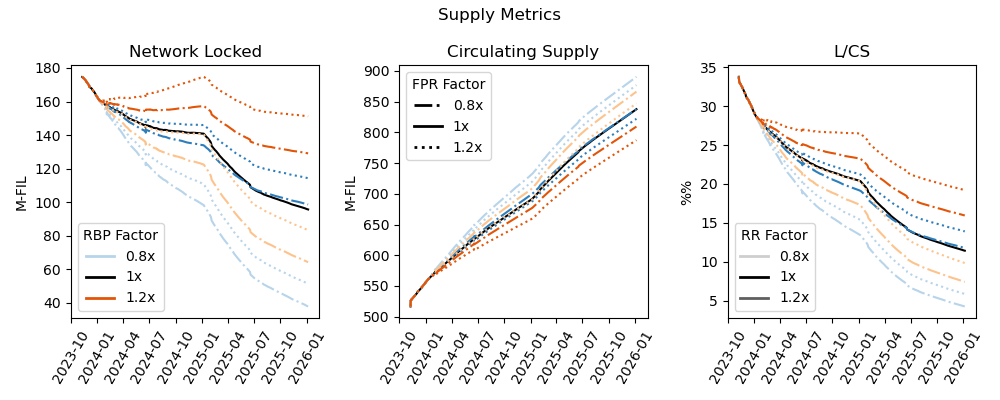

In [23]:
plot_supply_scenarios()

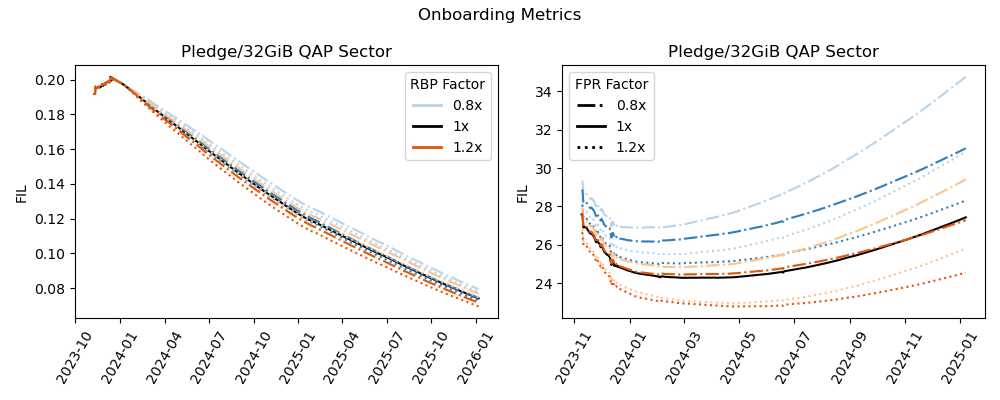

In [24]:
plot_onboarding_scenarios()

### Check Various Levels of Onboarding for how fast they catch up to Baseline

In [25]:
lock_target = 0.3
sector_duration = 365
# fix RR & FPR
rbp_values = [8, 10, 12]
cvec_idx = np.linspace(0.2,0.8,len(rbp_values))

rr_factors = [0.8, 1.0, 1.2]
fpr_factors = [0.8, 1.0, 1.2]
factors = list(itertools.product(*[rr_factors, fpr_factors]))

rbp2results = {}
for rbp in rbp_values:
    qap_catchup_results = []
    for factor in factors:
        rr_factor, fpr_factor = factor[0], factor[1]
        rbp_vec = jnp.ones(forecast_length)*rbp
        rr_vec = jnp.ones(forecast_length)*min(0.99, hist_median_rr*rr_factor)
        fpr_vec = jnp.ones(forecast_length)*min(0.99, hist_median_fpr*fpr_factor)
        simulation_results = sim.run_sim(
            rbp_vec,
            rr_vec,
            fpr_vec,
            lock_target,
        
            start_date,
            current_date,
            forecast_length,
            sector_duration,
            offline_data
        )
        qap_catchup_results.append(simulation_results)
    rbp2results[rbp] = qap_catchup_results

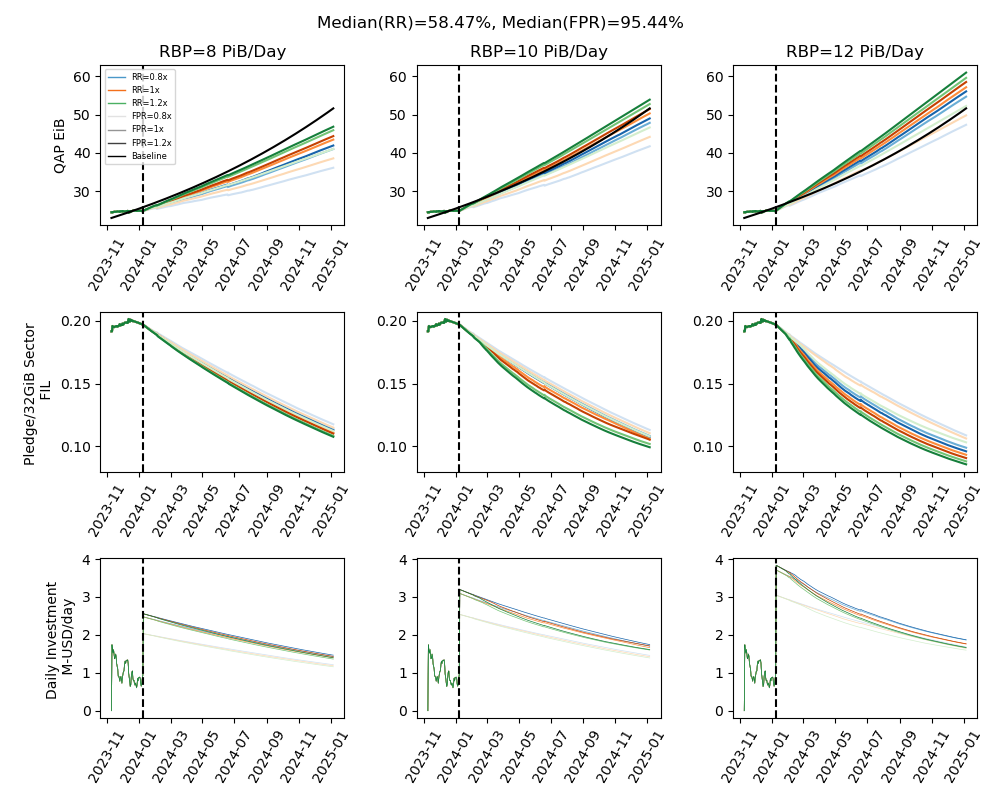

In [53]:
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples']]
cvec_idx = np.linspace(0.2,0.8,len(fpr_factors))
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,8))

FIL_price = 5.00
reinvestment_amt = 0.8
sectors32gib_per_pib = 1048576/32
current_day = (current_date - start_date).days

config2totalinvestment = {}
config2exceedbaseline = {}
for xx, rbp_value in enumerate(rbp_values):
    qap_catchup_results = rbp2results[rbp_value]
    
    axx = ax[0,xx]
    for ii, factor in enumerate(factors):
        rr_factor, fpr_factor = factor[0], factor[1]
        cc = colors[rr_factors.index(rr_factor)](cvec_idx[fpr_factors.index(fpr_factor)])
        qa_y = qap_catchup_results[ii]['qa_total_power_eib'][:-365]
        baseline_y = qap_catchup_results[ii]['network_baseline_EIB'][:-365]
        axx.plot(macro_t[:-365], qa_y, color=cc)

        last_qa_value = qa_y[-1]
        last_baseline_value = baseline_y[-1]
        config2exceedbaseline[(rbp_value, rr_factor, fpr_factor)] = (float(last_qa_value) >= float(last_baseline_value))
    axx.plot(macro_t[:-365], qap_catchup_results[0]['network_baseline_EIB'][:-365], color='k')
    axx.axvline(current_date, linestyle='--', color='k')
    if xx == 0:
        axx.set_ylabel('QAP EiB')
    # axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.set_title('RBP=%d PiB/Day' % (rbp_value,))

    if xx == 0:
        # make custom legend
        custom_lines = [
            Line2D([0], [0], color=colors[0](0.6), lw=1),
            Line2D([0], [0], color=colors[1](0.6), lw=1),
            Line2D([0], [0], color=colors[2](0.6), lw=1),
            Line2D([0], [0], color=mpl.colormaps['Greys'](cvec_idx[0]), lw=1),
            Line2D([0], [0], color=mpl.colormaps['Greys'](cvec_idx[1]), lw=1),
            Line2D([0], [0], color=mpl.colormaps['Greys'](cvec_idx[2]), lw=1),
            Line2D([0], [0], color='k', lw=1),
        ]
        axx.legend(custom_lines, ['RR=0.8x', 'RR=1x', 'RR=1.2x','FPR=0.8x', 'FPR=1x', 'FPR=1.2x', 'Baseline'], fontsize=6)

    axx = ax[1,xx]
    for ii, factor in enumerate(factors):
        rr_factor, fpr_factor = factor[0], factor[1]
        cc = colors[rr_factors.index(rr_factor)](cvec_idx[fpr_factors.index(fpr_factor)])
        axx.plot(macro_t[:-365], qap_catchup_results[ii]['day_pledge_per_QAP'][:-365], color=cc)
    axx.axvline(current_date, linestyle='--', color='k')
    if xx == 0:
        axx.set_ylabel('Pledge/32GiB Sector \n FIL')
    # axx.legend(fontsize=8)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)

    axx = ax[2,xx]
    for ii, factor in enumerate(factors):
        rr_factor, fpr_factor = factor[0], factor[1]
        cc = colors[rr_factors.index(rr_factor)](cvec_idx[fpr_factors.index(fpr_factor)])
        y_val_fil_new = qap_catchup_results[ii]['day_locked_pledge'][:-365] - qap_catchup_results[ii]['day_renewed_pledge'][:-365]
        y_val_musd = (y_val_fil_new*FIL_price)/1e6
        axx.plot(macro_t[:-365], y_val_musd, color=cc, linewidth=0.5)
        
        config2totalinvestment[(rbp_value, rr_factor, fpr_factor)] = np.sum(y_val_musd[current_day:])
    axx.axvline(current_date, linestyle='--', color='k')
    if xx == 0:
        axx.set_ylabel('Daily Investment \n M-USD/day')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)

# # sync the axes
ax[0,0].sharey(ax[0,2])
ax[0,1].sharey(ax[0,2])

ax[1,0].sharey(ax[1,2])
ax[1,1].sharey(ax[1,2])

ax[2,0].sharey(ax[2,2])
ax[2,1].sharey(ax[2,2])

plt.suptitle('Median(RR)=%0.02f%%, Median(FPR)=%0.02f%%' % (hist_median_rr*100, hist_median_fpr*100))
plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'investment.png'))

In [56]:
def get_heatmap_data(rbp_val):
    y = np.zeros((len(rr_factors), len(fpr_factors)))
    for k, v in config2totalinvestment.items():
        if k[0] == rbp_val:
            rr_idx = rr_factors.index(k[1])
            fpr_idx = fpr_factors.index(k[2])
            y[rr_idx,fpr_idx] = v
    return y

def get_baseline_exceed_condition(rbp_val):
    y = np.zeros((len(rr_factors), len(fpr_factors)))
    for k, v in config2exceedbaseline.items():
        if k[0] == rbp_val:
            rr_idx = rr_factors.index(k[1])
            fpr_idx = fpr_factors.index(k[2])
            y[rr_idx,fpr_idx] = v
    return y


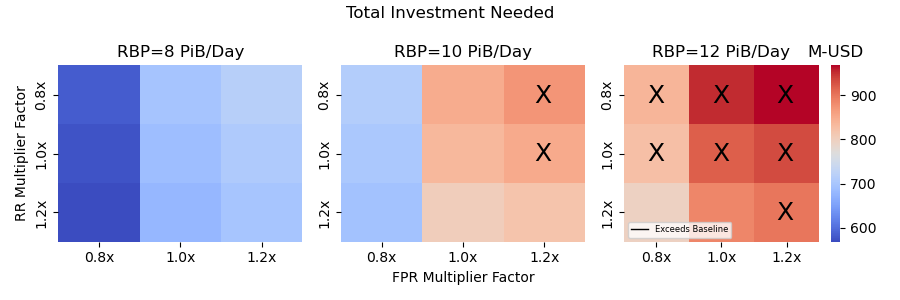

In [76]:
# plt.figure(figsize=(4,3))
# plt.hist(config2totalinvestment.values())
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,3))

rbp8_heatmap = get_heatmap_data(8)
rbp10_heatmap = get_heatmap_data(10)
rbp12_heatmap = get_heatmap_data(12)
min_val = min(np.min(rbp8_heatmap), np.min(rbp10_heatmap), np.min(rbp12_heatmap))
max_val = max(np.max(rbp8_heatmap), np.max(rbp10_heatmap), np.max(rbp12_heatmap))

xtl = ['%0.1fx' % x for x in fpr_factors]
ytl = ['%0.1fx' % x for x in rr_factors]

idx2coord = {
    0:0.33/2,
    1:0.33 + 0.33/2,
    2:0.33*2 + 0.33/2
}

axx = ax[0]
sns.heatmap(rbp8_heatmap, ax=axx, xticklabels=xtl, yticklabels=ytl, cbar=False, vmin=min_val, vmax=max_val, cmap="coolwarm")
axx.set_title('RBP=8 PiB/Day')
axx.set_ylabel('RR Multiplier Factor')
annot_idxs = np.where(get_baseline_exceed_condition(8))
if len(annot_idxs[0]) > 0:
    for ii in range(len(annot_idxs[0])):
        xix = annot_idxs[0][ii]
        yix = annot_idxs[1][ii]
        # translate to heatmap, which is between 0 and 1
        spacing = 1.0/len(fpr_factors)
        axx.text(idx2coord[xix], idx2coord[yix], "X", fontsize=18, color='k', ha='center', va='center', transform=axx.transAxes)

axx = ax[1]
sns.heatmap(rbp10_heatmap, ax=axx, xticklabels=xtl, yticklabels=ytl, cbar=False, vmin=min_val, vmax=max_val, cmap="coolwarm")
axx.set_title('RBP=10 PiB/Day')
axx.set_xlabel('FPR Multiplier Factor')
annot_idxs = np.where(get_baseline_exceed_condition(10))
if len(annot_idxs[0]) > 0:
    for ii in range(len(annot_idxs[0])):
        xix = annot_idxs[0][ii]
        yix = annot_idxs[1][ii]
        # translate to heatmap, which is between 0 and 1
        spacing = 1.0/len(fpr_factors)
        axx.text(idx2coord[xix], idx2coord[yix], "X", fontsize=18, color='k', ha='center', va='center', transform=axx.transAxes)

axx = ax[2]
sns.heatmap(rbp12_heatmap, ax=axx, xticklabels=xtl, yticklabels=ytl, vmin=min_val, vmax=max_val, cmap="coolwarm")
axx.collections[0].colorbar.ax.set_title('M-USD')
axx.set_title('RBP=12 PiB/Day')
annot_idxs = np.where(get_baseline_exceed_condition(12))
if len(annot_idxs[0]) > 0:
    for ii in range(len(annot_idxs[0])):
        xix = annot_idxs[0][ii]
        yix = annot_idxs[1][ii]
        # translate to heatmap, which is between 0 and 1
        spacing = 1.0/len(fpr_factors)
        axx.text(idx2coord[xix], idx2coord[yix], "X", fontsize=18, color='k', ha='center', va='center', transform=axx.transAxes)

custom_lines = [
    Line2D([0], [0], color='k', lw=1),
]
axx.legend(custom_lines, ['Exceeds Baseline'], fontsize=6, loc='lower left')
plt.suptitle('Total Investment Needed')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'investment_total.png'))